# EE519 — Lecture 10A Notebook: Cepstrum & Homomorphic Speech Processing (Manifest Workflow)

**Goal :** Build deep intuition for **homomorphic speech processing** using the **real cepstrum**, including **quefrency-domain liftering** and reconstruction of **(i) spectral envelope** and **(ii) excitation/pitch structure**.

This notebook follows the same **hands-on protocol** as earlier Lectures:
- ✅ step-by-step explanations before major code
- ✅ micro-checkpoints + debugging hints
- ✅ **manifest workflow** (record/load → select segments → analyze → save plots)
- ✅ reflective questions at the end


## 0) Roadmap

1. Record / load speech clips (vowels + sentence + fricative).
2. Pick a clip and select a **time region** (seconds) to analyze.
3. Pick a **representative frame** inside that region.
4. Compute:
   - FFT magnitude → log magnitude
   - **real cepstrum** = IFFT(log magnitude)
5. Interpret quefrency (ms) and look for:
   - low-quefrency → envelope
   - pitch-period peak (voiced)
6. Apply **liftering** (low-pass vs high-pass in quefrency).
7. Reconstruct and compare spectra; save figures.


## 1) Environment setup (packages + quick checks)

Required: numpy, scipy, matplotlib  
Optional: sounddevice (recording), IPython audio playback


In [1]:
import os, json, math
from pathlib import Path
import numpy as np
import scipy.signal as sig
import scipy.fft as fft
import matplotlib.pyplot as plt

# Optional: recording in notebook
try:
    import sounddevice as sd
    HAS_SD = True
except Exception as e:
    HAS_SD = False
    print("sounddevice not available (recording disabled).", e)

# Optional: playback in notebook
try:
    from IPython.display import Audio, display
    HAS_IPY_AUDIO = True
except Exception:
    HAS_IPY_AUDIO = False

print("OK: numpy/scipy/matplotlib loaded.")
print("Recording available:", HAS_SD)
print("Inline audio playback available:", HAS_IPY_AUDIO)


OK: numpy/scipy/matplotlib loaded.
Recording available: True
Inline audio playback available: True


### 🔧 Debugging hint
If recording is blocked on your Jupyter environment, you can still:
- record externally (phone/voice memo)
- export as WAV
- drop into `EE519_L10A_Project/recordings/`


## 2) Project + manifest workflow

We create:
- `EE519_L10A_Project/recordings/`
- `EE519_L10A_Project/figures/`
- `EE519_L10A_Project/manifest.json`


In [2]:
PROJECT_ROOT = Path.cwd() / "EE519_L10A_Project"
REC_DIR = PROJECT_ROOT / "recordings"
FIG_DIR = PROJECT_ROOT / "figures"
MANIFEST_PATH = PROJECT_ROOT / "manifest.json"

for d in [REC_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

def load_manifest(path=MANIFEST_PATH):
    if path.exists():
        return json.loads(path.read_text())
    return {"course":"EE519","lecture":"10A","created_utc":None,"clips":[]}

def save_manifest(manifest, path=MANIFEST_PATH):
    if manifest.get("created_utc") is None:
        manifest["created_utc"] = str(np.datetime64("now"))
    path.write_text(json.dumps(manifest, indent=2))
    print("Saved manifest:", path)

manifest = load_manifest()
print("Clips in manifest:", len(manifest["clips"]))


Clips in manifest: 19


### Micro-checkpoint
- [ ] You see `EE519_L10A_Project` folder created
- [ ] You see `recordings/` and `figures/` created


## 3) WAV I/O + audio helpers (self-contained)


In [3]:
import wave

def write_wav(path: Path, x: np.ndarray, fs: int):
    x = np.asarray(x, dtype=np.float32)
    x = np.clip(x, -1.0, 1.0)
    x_i16 = (x * 32767.0).astype(np.int16)
    with wave.open(str(path), "wb") as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(fs)
        wf.writeframes(x_i16.tobytes())

def read_wav(path: Path):
    with wave.open(str(path), "rb") as wf:
        fs = wf.getframerate()
        n = wf.getnframes()
        x = np.frombuffer(wf.readframes(n), dtype=np.int16).astype(np.float32) / 32768.0
    return fs, x

def peak_normalize(x, target=0.98):
    m = np.max(np.abs(x)) + 1e-12
    return (x / m) * target

def play_audio(x, fs, label="audio"):
    if not HAS_IPY_AUDIO:
        print("(Audio playback not available)", label)
        return
    display(Audio(x, rate=fs))


## 4) Recording queue (optional)

Record multiple clips separately:
- vowel `/a/` (steady 1–2 s)
- fricative `/s/` (steady 1–2 s)
- a short sentence (2–3 s)

If you cannot record here, skip to **Load WAV files**.


In [4]:
def record_clip(seconds=2.0, fs=16000):
    if not HAS_SD:
        raise RuntimeError("sounddevice not available. Load wav files instead.")
    print(f"Recording {seconds:.1f}s @ {fs} Hz ...")
    x = sd.rec(int(seconds*fs), samplerate=fs, channels=1, dtype="float32")
    sd.wait()
    return fs, x.squeeze()

def add_clip_to_manifest(filename, label, fs, notes=""):
    clip = {
        "filename": filename,
        "label": label,
        "fs": int(fs),
        "notes": notes,
        "added_utc": str(np.datetime64("now")),
        "selections": {}
    }
    manifest["clips"].append(clip)
    save_manifest(manifest)
    return len(manifest["clips"]) - 1

print("Ready.")


Ready.


In [5]:
# ----------- Record vowel /a/ -----------
DO_RECORD = False  # set True in class
if DO_RECORD:
    fs, x = record_clip(seconds=2.0, fs=16000)
    x = peak_normalize(x)
    fname = "student_vowel_a.wav"
    write_wav(REC_DIR/fname, x, fs)
    idx = add_clip_to_manifest(fname, label="vowel_a", fs=fs, notes="steady /a/")
    print("Added clip index:", idx)
    play_audio(x, fs, "vowel /a/")
else:
    print("Skipping (set DO_RECORD=True to record).")


Skipping (set DO_RECORD=True to record).


In [6]:
# ----------- Record fricative /s/ -----------
DO_RECORD = False
if DO_RECORD:
    fs, x = record_clip(seconds=2.0, fs=16000)
    x = peak_normalize(x)
    fname = "student_fricative_s.wav"
    write_wav(REC_DIR/fname, x, fs)
    idx = add_clip_to_manifest(fname, label="fricative_s", fs=fs, notes="steady /s/")
    print("Added clip index:", idx)
    play_audio(x, fs, "fricative /s/")
else:
    print("Skipping (set DO_RECORD=True).")


Skipping (set DO_RECORD=True).


In [7]:
# ----------- Record a short sentence -----------
DO_RECORD = False
if DO_RECORD:
    fs, x = record_clip(seconds=3.0, fs=16000)
    x = peak_normalize(x)
    fname = "student_sentence.wav"
    write_wav(REC_DIR/fname, x, fs)
    idx = add_clip_to_manifest(fname, label="sentence", fs=fs, notes="short sentence")
    print("Added clip index:", idx)
    play_audio(x, fs, "sentence")
else:
    print("Skipping (set DO_RECORD=True).")


Skipping (set DO_RECORD=True).


## 5) Load WAV files (recommended fallback)

Place WAV files into `EE519_L10A_Project/recordings/` and run this cell to auto-add them to the manifest.


In [4]:
existing = set([c["filename"] for c in manifest["clips"]])
wav_files = sorted([p.name for p in REC_DIR.glob("*.wav")])

added = 0
for wf in wav_files:
    if wf not in existing:
        fs, _ = read_wav(REC_DIR/wf)
        add_clip_to_manifest(wf, label="imported", fs=fs, notes="auto-import")
        added += 1

print("Found wav files:", wav_files)
print("Newly added:", added)
print("Total clips:", len(manifest["clips"]))


Found wav files: ['student_fricative_s.wav', 'student_sentence.wav', 'student_vowel_a.wav', 'student_vowel_i.wav', 'student_vowel_u.wav']
Newly added: 0
Total clips: 19


## 6) Pick a clip to analyze (student-controlled)


In [5]:
def list_clips():
    for i,c in enumerate(manifest["clips"]):
        print(f"[{i}] {c['label']:12s}  {c['filename']}  fs={c['fs']}  notes={c.get('notes','')}")

list_clips()


[0] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[1] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[2] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[3] fricative_s   student_fricative_s.wav  fs=16000  notes=steady /s/
[4] sentence      student_sentence.wav  fs=16000  notes=short sentence
[5] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[6] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[7] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[8] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[9] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[10] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[11] fricative_s   student_fricative_s.wav  fs=16000  notes=steady /s/
[12] sentence      student_sentence.wav  fs=16000  notes=short sentence
[13] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[14] vowel_a       student_vowel_a.wav  fs=16000  note

In [27]:
CLIP_IDX = 3  # <-- change
clip = manifest["clips"][CLIP_IDX]
fs, x = read_wav(REC_DIR / clip["filename"])
x = peak_normalize(x)

print("Selected:", CLIP_IDX, clip["label"], clip["filename"], "fs=", fs, "len_sec=", len(x)/fs)
play_audio(x, fs, f"clip {CLIP_IDX}: {clip['label']}")


Selected: 3 fricative_s student_fricative_s.wav fs= 16000 len_sec= 2.0


## 7) Select a time range (seconds) → store in manifest

Pick a steady region:
- vowel: middle 0.5–1.0 s
- fricative: middle region


In [28]:
def frame_signal(x, N, H):
    if len(x) < N:
        x = np.pad(x, (0, N-len(x)))
    num = 1 + (len(x) - N)//H
    idx = np.arange(N)[None,:] + H*np.arange(num)[:,None]
    return x[idx]

def seconds_to_samples(t0, t1, fs, xlen):
    s0 = int(max(0, round(t0*fs)))
    s1 = int(min(xlen, round(t1*fs)))
    if s1 <= s0:
        raise ValueError("Bad selection: t1 must be > t0")
    return s0, s1

def samples_to_frame_range(s0, s1, N, H, xlen):
    f0 = max(0, int((s0 - N)//H) + 1)
    f1 = min(int((s1)//H), int((xlen-N)//H))
    if f1 < f0:
        f0 = max(0, int(s0//H))
        f1 = min(int((xlen-N)//H), f0)
    return f0, f1

WIN_MS, HOP_MS = 25, 10
N = int(WIN_MS*1e-3*fs)
H = int(HOP_MS*1e-3*fs)
window = sig.windows.hann(N, sym=False)

print("Frame length N:", N, "Hop H:", H)


Frame length N: 400 Hop H: 160


In [29]:
segment_name = "vowel_mid"
t0, t1 = 1.0, 1.5  # <-- change

s0, s1 = seconds_to_samples(t0, t1, fs, len(x))
f0, f1 = samples_to_frame_range(s0, s1, N, H, len(x))

print("Time range:", (t0, t1), "sec")
print("Sample range:", (s0, s1))
print("Frame range:", (f0, f1))

clip = manifest["clips"][CLIP_IDX]
clip.setdefault("selections", {}).setdefault("analysis_segments", {})
clip["selections"]["analysis_segments"][segment_name] = {
    "t0": float(t0), "t1": float(t1),
    "s0": int(s0), "s1": int(s1),
    "win_ms": float(WIN_MS), "hop_ms": float(HOP_MS),
    "N": int(N), "H": int(H),
    "frame_range": [int(f0), int(f1)]
}
manifest["clips"][CLIP_IDX] = clip
save_manifest(manifest)


Time range: (1.0, 1.5) sec
Sample range: (16000, 24000)
Frame range: (98, 150)
Saved manifest: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\manifest.json


### Plot waveform + selection (and save)


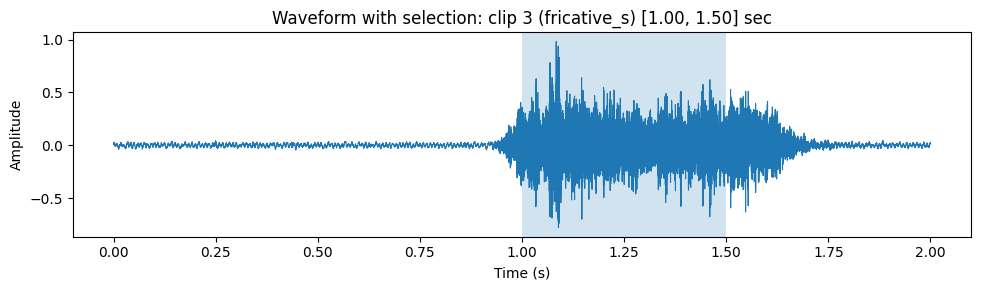

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\wave_sel_clip3_vowel_mid.png


In [30]:
import re

def save_fig(fig, name):
    out = FIG_DIR / name
    fig.savefig(out, dpi=150, bbox_inches="tight")
    print("Saved figure:", out)
    return out

SAVE_PLOT = True

t = np.arange(len(x))/fs
fig = plt.figure(figsize=(10,3))
plt.plot(t, x, linewidth=0.8)
plt.axvspan(t0, t1, alpha=0.2)
plt.title(f"Waveform with selection: clip {CLIP_IDX} ({clip['label']}) [{t0:.2f}, {t1:.2f}] sec")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

if SAVE_PLOT:
    safe_label = re.sub(r"[^a-zA-Z0-9_]+","_", f"wave_sel_clip{CLIP_IDX}_{segment_name}")
    save_fig(fig, f"{safe_label}.png")


## 8) Compute spectrum for a representative frame

We start with a **single frame** for clearest cepstrum interpretation.


Representative frame: 124 within (98, 150)


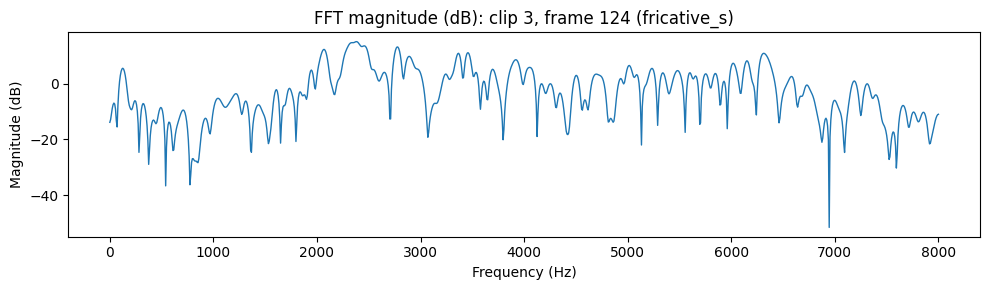

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\fft_db_clip3_frame124_vowel_mid.png


In [31]:
sel = clip["selections"]["analysis_segments"][segment_name]
f0, f1 = sel["frame_range"]
FRAME_IDX = int(round((f0 + f1) / 2))  # middle
print("Representative frame:", FRAME_IDX, "within", (f0, f1))

frames = frame_signal(x, N, H)
frame = frames[FRAME_IDX] * window

NFFT = 2048 if fs <= 16000 else 4096
X = fft.rfft(frame, n=NFFT)
mag = np.abs(X) + 1e-12
logmag = np.log(mag)  # natural log

freqs = np.linspace(0, fs/2, len(mag))

fig = plt.figure(figsize=(10,3))
plt.plot(freqs, 20*np.log10(mag), linewidth=1.0)
plt.title(f"FFT magnitude (dB): clip {CLIP_IDX}, frame {FRAME_IDX} ({clip['label']})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.tight_layout()
plt.show()

if SAVE_PLOT:
    safe_label = re.sub(r"[^a-zA-Z0-9_]+","_", f"fft_db_clip{CLIP_IDX}_frame{FRAME_IDX}_{segment_name}")
    save_fig(fig, f"{safe_label}.png")


## 9) Real cepstrum (homomorphic step)

Real cepstrum:
\begin{align}
c[n] = \mathcal{F}^{-1}\{\log|X(e^{j\omega})|\}
\end{align}

- x-axis is **quefrency** (seconds/ms), not frequency.
- low quefrency → slowly varying spectral shape (envelope)
- pitch periodicity (voiced) often appears as a peak near $T_0=1/f_0$.


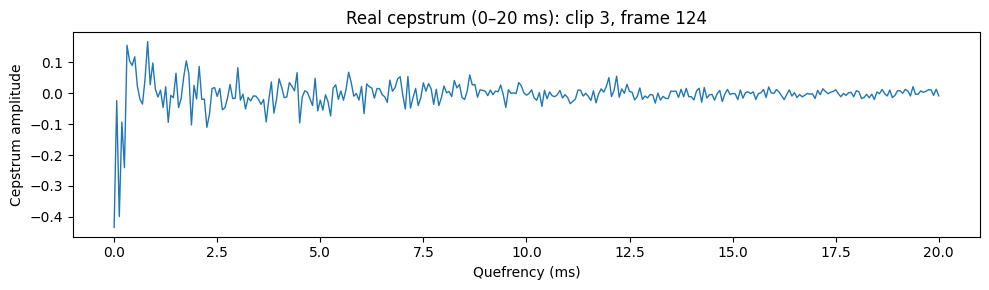

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\cepstrum_clip3_frame124_vowel_mid.png


In [32]:
cep = fft.irfft(logmag, n=NFFT)
quef = np.arange(NFFT)/fs
quef_ms = quef*1000.0

QMAX_MS = 20.0
qmask = quef_ms <= QMAX_MS

fig = plt.figure(figsize=(10,3))
plt.plot(quef_ms[qmask], cep[qmask], linewidth=1.0)
plt.title(f"Real cepstrum (0–{QMAX_MS:.0f} ms): clip {CLIP_IDX}, frame {FRAME_IDX}")
plt.xlabel("Quefrency (ms)")
plt.ylabel("Cepstrum amplitude")
plt.tight_layout()
plt.show()

if SAVE_PLOT:
    safe_label = re.sub(r"[^a-zA-Z0-9_]+","_", f"cepstrum_clip{CLIP_IDX}_frame{FRAME_IDX}_{segment_name}")
    save_fig(fig, f"{safe_label}.png")


## 10) Liftering (filtering in quefrency domain)

We apply a **low-pass lifter** to keep the envelope, and a **high-pass lifter** to keep excitation-ish structure.


In [34]:
def lifter_lowpass(cep, fs, q_cut_ms):
    q = np.arange(len(cep))/fs * 1000.0
    mask = (q <= q_cut_ms).astype(float)
    return cep * mask, mask

def lifter_highpass(cep, fs, q_cut_ms):
    q = np.arange(len(cep))/fs * 1000.0
    mask = (q >= q_cut_ms).astype(float)
    return cep * mask, mask

Q_CUT_MS = 2.5  # try 1.5, 2.5, 4.0
cep_env, mask_env = lifter_lowpass(cep, fs, Q_CUT_MS)
cep_exc, mask_exc = lifter_highpass(cep, fs, Q_CUT_MS)
print("Using q-cut (ms):", Q_CUT_MS)


Using q-cut (ms): 2.5


### Plot lifter masks (0–20 ms)


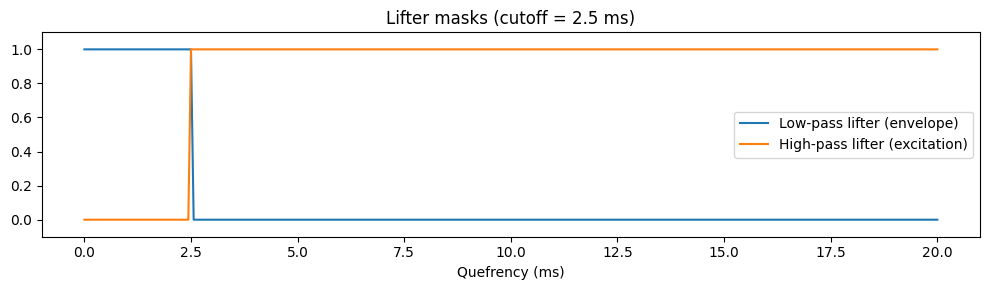

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\lifter_masks_qcut2_5ms.png


In [35]:
fig = plt.figure(figsize=(10,3))
plt.plot(quef_ms[qmask], mask_env[qmask], label="Low-pass lifter (envelope)")
plt.plot(quef_ms[qmask], mask_exc[qmask], label="High-pass lifter (excitation)")
plt.ylim([-0.1, 1.1])
plt.title(f"Lifter masks (cutoff = {Q_CUT_MS} ms)")
plt.xlabel("Quefrency (ms)")
plt.legend()
plt.tight_layout()
plt.show()

if SAVE_PLOT:
    safe_label = re.sub(r"[^a-zA-Z0-9_]+","_", f"lifter_masks_qcut{Q_CUT_MS:.1f}ms")
    save_fig(fig, f"{safe_label}.png")


## 11) Reconstruct spectra from liftered cepstrum

Steps:
- FFT(cepstrum) → liftered log magnitude
- exp(·) → magnitude
- compare with original (normalized-to-peak for shape)


In [36]:
def db(x):
    return 20*np.log10(np.maximum(x, 1e-12))

logmag_env = np.real(fft.rfft(cep_env, n=NFFT))
logmag_exc = np.real(fft.rfft(cep_exc, n=NFFT))

mag_env = np.exp(logmag_env)
mag_exc = np.exp(logmag_exc)

mag_db_n = db(mag) - np.max(db(mag))
env_db_n = db(mag_env) - np.max(db(mag_env))
exc_db_n = db(mag_exc) - np.max(db(mag_exc))


### Overlay: original vs cepstral envelope


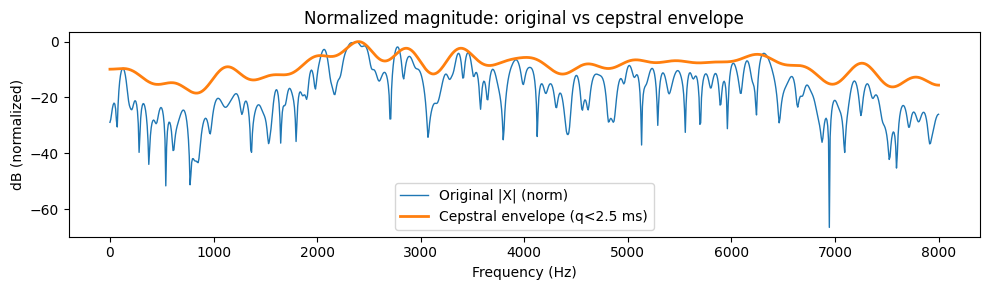

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\env_overlay_clip3_frame124_qcut2_5ms.png


In [37]:
fig = plt.figure(figsize=(10,3))
plt.plot(freqs, mag_db_n, label="Original |X| (norm)", linewidth=1.0)
plt.plot(freqs, env_db_n, label=f"Cepstral envelope (q<{Q_CUT_MS} ms)", linewidth=2.0)
plt.title("Normalized magnitude: original vs cepstral envelope")
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB (normalized)")
plt.legend()
plt.tight_layout()
plt.show()

if SAVE_PLOT:
    safe_label = re.sub(r"[^a-zA-Z0-9_]+","_", f"env_overlay_clip{CLIP_IDX}_frame{FRAME_IDX}_qcut{Q_CUT_MS:.1f}ms")
    save_fig(fig, f"{safe_label}.png")


### Overlay: original vs high-quefrency component


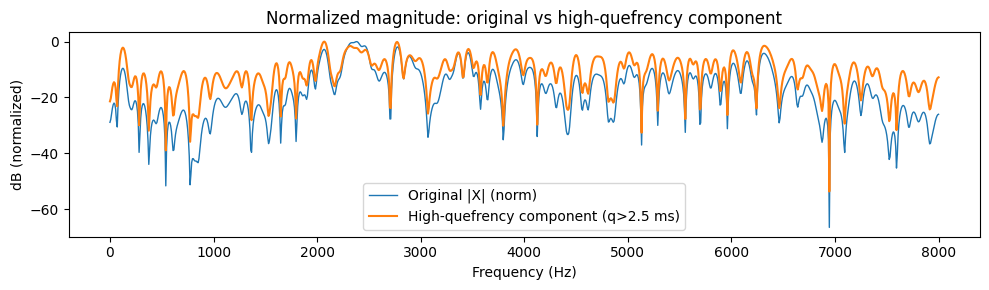

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\exc_overlay_clip3_frame124_qcut2_5ms.png


In [38]:
fig = plt.figure(figsize=(10,3))
plt.plot(freqs, mag_db_n, label="Original |X| (norm)", linewidth=1.0)
plt.plot(freqs, exc_db_n, label=f"High-quefrency component (q>{Q_CUT_MS} ms)", linewidth=1.5)
plt.title("Normalized magnitude: original vs high-quefrency component")
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB (normalized)")
plt.legend()
plt.tight_layout()
plt.show()

if SAVE_PLOT:
    safe_label = re.sub(r"[^a-zA-Z0-9_]+","_", f"exc_overlay_clip{CLIP_IDX}_frame{FRAME_IDX}_qcut{Q_CUT_MS:.1f}ms")
    save_fig(fig, f"{safe_label}.png")


## 12) Cutoff sweep (student exploration)

Smaller cutoff → smoother envelope; larger cutoff → more detail (may start tracking harmonics).


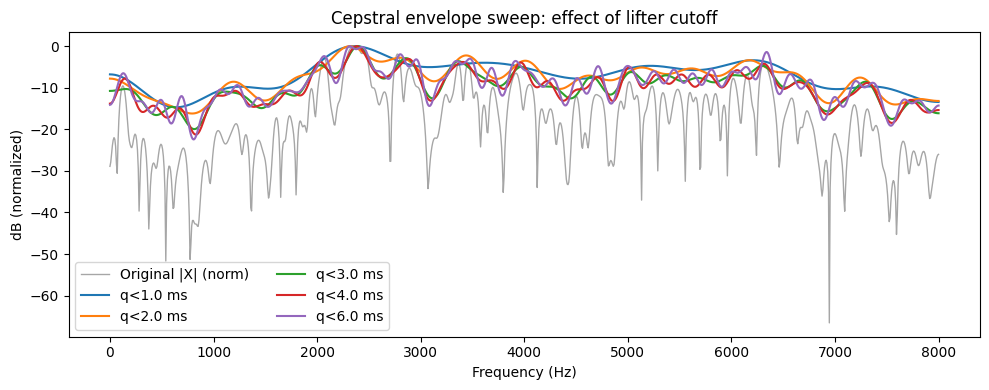

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\env_sweep_clip3_frame124.png


In [39]:
Q_CUT_LIST = [1.0, 2.0, 3.0, 4.0, 6.0]

fig = plt.figure(figsize=(10,4))
plt.plot(freqs, mag_db_n, color="k", alpha=0.35, linewidth=1.0, label="Original |X| (norm)")

for qcut in Q_CUT_LIST:
    cep_env, _ = lifter_lowpass(cep, fs, qcut)
    logmag_env = np.real(fft.rfft(cep_env, n=NFFT))
    mag_env = np.exp(logmag_env)
    env_db_n = db(mag_env) - np.max(db(mag_env))
    plt.plot(freqs, env_db_n, linewidth=1.5, label=f"q<{qcut} ms")

plt.title("Cepstral envelope sweep: effect of lifter cutoff")
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB (normalized)")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

if SAVE_PLOT:
    safe_label = re.sub(r"[^a-zA-Z0-9_]+","_", f"env_sweep_clip{CLIP_IDX}_frame{FRAME_IDX}")
    save_fig(fig, f"{safe_label}.png")


## 13) Optional: estimate pitch period from cepstrum peak (voiced only)

Search for a peak in 2–20 ms (≈50–500 Hz).


In [40]:
TMIN_MS, TMAX_MS = 5.0, 20.0
mask = (quef_ms >= TMIN_MS) & (quef_ms <= TMAX_MS)

peak_idx = np.argmax(cep[mask])
q_idx = np.where(mask)[0][peak_idx]

T0_ms = quef_ms[q_idx]
f0_est = 1000.0 / T0_ms

print(f"Estimated T0 ≈ {T0_ms:.2f} ms  => f0 ≈ {f0_est:.1f} Hz")
print("If this is a fricative/silence frame, this estimate will be unreliable.")


Estimated T0 ≈ 5.69 ms  => f0 ≈ 175.8 Hz
If this is a fricative/silence frame, this estimate will be unreliable.


### Plot cepstrum with pitch annotation


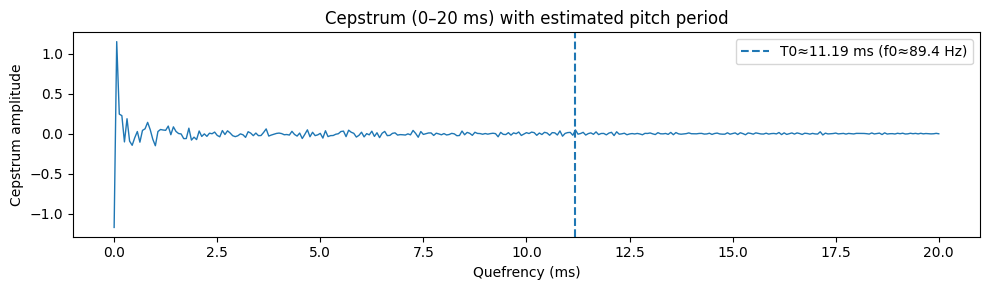

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\cep_pitch_clip0_frame124.png


In [19]:
fig = plt.figure(figsize=(10,3))
plt.plot(quef_ms[qmask], cep[qmask], linewidth=1.0)
plt.axvline(T0_ms, linestyle="--", linewidth=1.5, label=f"T0≈{T0_ms:.2f} ms (f0≈{f0_est:.1f} Hz)")
plt.title("Cepstrum (0–20 ms) with estimated pitch period")
plt.xlabel("Quefrency (ms)")
plt.ylabel("Cepstrum amplitude")
plt.legend()
plt.tight_layout()
plt.show()

if SAVE_PLOT:
    safe_label = re.sub(r"[^a-zA-Z0-9_]+","_", f"cep_pitch_clip{CLIP_IDX}_frame{FRAME_IDX}")
    save_fig(fig, f"{safe_label}.png")


## 14) Debugging & common pitfalls

- Cepstrum looks flat → you selected silence/unvoiced, or too noisy.
- Envelope tracks harmonics → cutoff too large; reduce q-cut (1–3 ms).
- Pitch estimate nonsense → frame not voiced or includes transitions; pick a different frame.

### Micro-checkpoint
- [ ] On a vowel, you typically see a peak around 5–15 ms (not guaranteed, but common).
- [ ] Low-pass lifter yields a smooth envelope.


## 15) Save summary back into the manifest


In [20]:
summary = {
    "segment_name": segment_name,
    "representative_frame": int(FRAME_IDX),
    "NFFT": int(NFFT),
    "q_cut_ms": float(Q_CUT_MS),
    "pitch_est_hz": float(f0_est),
    "pitch_T0_ms": float(T0_ms),
}
clip = manifest["clips"][CLIP_IDX]
clip.setdefault("selections", {})["cepstrum_summary"] = summary
manifest["clips"][CLIP_IDX] = clip
save_manifest(manifest)

print(json.dumps(summary, indent=2))


Saved manifest: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\manifest.json
{
  "segment_name": "vowel_mid",
  "representative_frame": 124,
  "NFFT": 2048,
  "q_cut_ms": 2.5,
  "pitch_est_hz": 89.3854748603352,
  "pitch_T0_ms": 11.1875
}


## 16) Wrap-up

### What you learned
- real cepstrum = IFFT(log|FFT|)
- quefrency axis meaning
- low-quefrency ↔ envelope, high-quefrency ↔ excitation-ish
- liftering separates these components
- cepstrum can reveal pitch periodicity (voiced frames)





## 🧠 Reflection (Lecture 10A)

### Common mistakes to notice
- selecting onset/offset (non-stationary)
- too-large q-cut (envelope tracks harmonics)
- expecting pitch peak on fricatives/silence
- confusing quefrency (ms) with frequency (Hz)

### Reflective questions (answer 2–4 sentences each)
1. For your vowel frame: where is the cepstral peak (ms)? Is the implied f0 reasonable?
2. How did the envelope change from q-cut 1 ms to 6 ms?
3. Compare vowel vs fricative cepstrum: what differs, and why?
4. If your pitch estimate was wrong, what is the most likely reason?

### Quick self-check
- [ ] I can explain what the real cepstrum is.
- [ ] I can explain liftering.
- [ ] I saved at least 2 figures (cepstrum + envelope overlay).


### Answers

1. The vowel didn't have anything noticeable to I tried the fricative. The peak was about 2.1 ms while the implied was slightly higher but reasonable.
2. The 6 ms q cut had less smooth envelope. The 1 ms had lower quefrequencies
3. The vowel was much flatter than the fricative. This is likely because the vowel is quasi-periodic.
4. The frame I selected may have been wrong for the vowel. I tried changing clips as well but didn't notice much difference.